In [1]:
import numpy as np
import roboticstoolbox as rtb
from spatialmath import *
from math import pi
import matplotlib.pyplot as plt
from matplotlib import cm
np.set_printoptions(linewidth=100, formatter={'float': lambda x: f"{x:8.4g}" if abs(x) > 1e-10 else f"{0:8.4g}"})

%matplotlib notebook

The Toolbox supports models defined using a number of different conventions.  We will load a very classical model, a Puma560 robot defined in terms of standard Denavit-Hartenberg parameters

In [2]:
p560 = rtb.models.DH.Puma560()

Now we can display the simple Denavit-Hartenberg parameter model

In [3]:
print(p560)

┏━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┓
┃θⱼ  ┃         dⱼ         ┃   aⱼ   ┃   ⍺ⱼ   ┃   q⁻    ┃   q⁺   ┃
┣━━━━╋━━━━━━━━━━━━━━━━━━━━╋━━━━━━━━╋━━━━━━━━╋━━━━━━━━━╋━━━━━━━━┫
┃ q1 ┃ 0.6718299999999999 ┃      0 ┃  90.0° ┃ -160.0° ┃ 160.0° ┃
┃ q2 ┃                  0 ┃ 0.4318 ┃   0.0° ┃ -110.0° ┃ 110.0° ┃
┃ q3 ┃            0.15005 ┃ 0.0203 ┃ -90.0° ┃ -135.0° ┃ 135.0° ┃
┃ q4 ┃             0.4318 ┃      0 ┃  90.0° ┃ -266.0° ┃ 266.0° ┃
┃ q5 ┃                  0 ┃      0 ┃ -90.0° ┃ -100.0° ┃ 100.0° ┃
┃ q6 ┃                  0 ┃      0 ┃   0.0° ┃ -266.0° ┃ 266.0° ┃
┗━━━━┻━━━━━━━━━━━━━━━━━━━━┻━━━━━━━━┻━━━━━━━━┻━━━━━━━━━┻━━━━━━━━┛

┌─────┬─────┬──────┬───────┬─────┬──────┬─────┐
│name │ q0  │ q1   │ q2    │ q3  │ q4   │ q5  │
├─────┼─────┼──────┼───────┼─────┼──────┼─────┤
│  qz │  0° │  0°  │  0°   │  0° │  0°  │  0° │
│  qr │  0° │  90° │ -90°  │  0° │  0°  │  0° │
│  qs │  0° │  0°  │ -90°  │  0° │  0°  │  0° │
│  qn │  0° │  45° │  180° │  0° │  45° │  0° │
└─────┴─────┴

The first table shows the kinematic parameters, and from the column titles we can see clearly that this is expressed in terms of standard Denavit-Hartenberg parameters.  The first column shows that the joint variables qi are rotations since they are in the θ column.  Joint limits are also shown.  Joint flip (motion in the opposite sense) would be indicated by the joint variable being shown as for example like `-q3`, and joint offsets by being shown as for example like `q2 + 45°`.

The second table shows some named joint configurations.  For example `p560.qr` is 

In [4]:
p560.qr

array([       0,    1.571,   -1.571,        0,        0,        0])

If the robot had a base or tool transform they would be listed in this table also.

This object is a subclass of `DHRobot`, equivalent to the `SerialLink` class in the MATLAB version of the Toolbox.
This class has many methods and attributes, and we will explore some of them in this notebook.

We can easily display the robot graphically

<IPython.core.display.Javascript object>


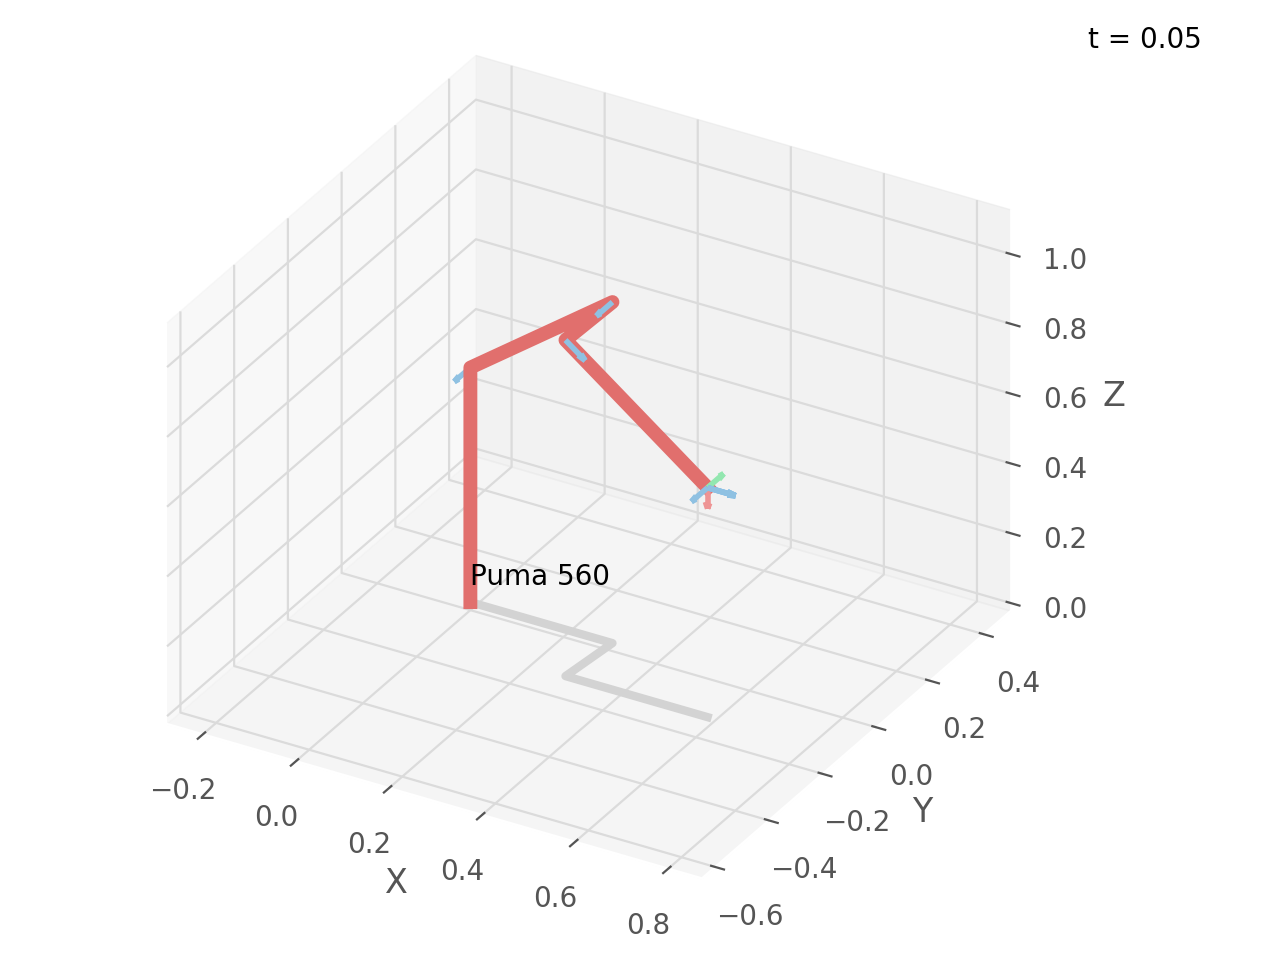

In [5]:
p560.plot(p560.qn);

where `qn` is one of the named configurations shown above, and has the robot positioned to work above a table top.  You can use the mouse to rotate the plot and view the robot from different directions.  The grey line is the _shadow_ which is a projection of the robot onto the xy-plane.

In this particular case the end-effector pose is given by the forward kinematics

In [6]:
p560.fkine(p560.qn)

SE3:   0           0           1           0.596303     
       0           1           0          -0.15005      
      -1           0           0           0.657476     
       0           0           0           1            
    

which is a 4x4 SE(3) matrix displayed in a color coded way with rotation matrix in red, translation vector in blue, and constant elements in grey.  This is an instance of an `SE3` object safely encapsulates the SE(3) matrix.  This class, and related ones, are implemented by the [Spatial Math Toolbox for Python](https://github.com/petercorke/spatialmath-python).

You can verify the end-effector position, the blue numbers are from top to bottom the x-, y- and z-coordinates of the end-effector position, match the plot shown above.

We can manually adjust the joint angles of this robot (click and drag the sliders) to see how the shape of the robot changes and how the end-effector pose changes

In [7]:
# p560.teach(); # works from console, hangs in Jupyter

An important problem in robotics is _inverse kinematics_, determining the joint angles to put the robot's end effector at a particular pose.

Suppose we want the end-effector to be at position (0.5, 0.2, 0.1) and to have its gripper pointing (its _approach vector_) in the x-direction, and its fingers one above the other so that its _orientation vector_ is parallel to the z-axis.

We can specify that pose by composing two SE(3) matrices:

1. a pure translation
2. a pure rotation defined in terms of the orientation and approach vectors

In [8]:
T = SE3(0.5, 0.2, 0.5) * SE3.OA([0,0,1], [1,0,0])
T

SE3:   0           0           1           0.5          
       1           0           0           0.2          
       0           1           0           0.5          
       0           0           0           1            
    

Now we can compute the joint angles that results in this pose

In [9]:
sol = p560.ikine_LM(T)

which returns the joint coordinates as well as solution status

In [10]:
sol

IKsolution(q=array([  0.6629,    -1.21,   0.2528,  -0.9351,  -0.8707,    2.289]), success=True, reason=None, iterations=11, residual=4.40509410010698e-12)

indicating, in this case, that there is no failure. The joint coordinates are

In [11]:
sol.q

array([  0.6629,    -1.21,   0.2528,  -0.9351,  -0.8707,    2.289])

and we can confirm that this is indeed an inverse kinematic solution by computing the forward kinematics

In [12]:
p560.fkine(sol.q)

SE3:   1.04922e-12-9.33675e-13 1           0.5          
       1          -6.70186e-13-1.04933e-12 0.2          
       6.70242e-13 1           9.33642e-13 0.5          
       0           0           0           1            
    

which matches the original transform.

A simple trajectory between two joint configuration is

In [13]:
qt = rtb.tools.trajectory.jtraj(p560.qz, sol.q, 50)

The result is a _namedtuple_ with attributes `q` containing the joint angles, as well as `qd`, `qdd` and `t` which hold the joint velocity, joint accelerations and time respectively.  

The joint angles are a matrix with one column per joint and one row per timestep, and time increasing with row number.

In [14]:
qt.q

array([[       0,        0,        0,        0,        0,        0],
       [5.463e-05, -9.971e-05, 2.084e-05, -7.707e-05, -7.176e-05, 0.0001886],
       [0.0004236, -0.0007731, 0.0001616, -0.0005976, -0.0005564, 0.001463],
       [0.001385, -0.002528, 0.0005282, -0.001954, -0.001819, 0.004782],
       [0.003179, -0.005801, 0.001212, -0.004485, -0.004175,  0.01098],
       [0.006009, -0.01097, 0.002292, -0.008477, -0.007893,  0.02075],
       [ 0.01004, -0.01833, 0.003831, -0.01417, -0.01319,  0.03468],
       [ 0.01542, -0.02814, 0.005882, -0.02176, -0.02026,  0.05324],
       [ 0.02224,  -0.0406, 0.008484, -0.03138, -0.02922,   0.0768],
       [ 0.03059, -0.05583,  0.01167, -0.04315, -0.04018,   0.1056],
       [  0.0405, -0.07392,  0.01545, -0.05714,  -0.0532,   0.1398],
       [ 0.05201, -0.09492,  0.01984, -0.07337, -0.06831,   0.1796],
       [  0.0651,  -0.1188,  0.02483, -0.09184, -0.08551,   0.2248],
       [ 0.07975,  -0.1456,  0.03042,  -0.1125,  -0.1048,   0.2754],
       [

We can plot this trajectory as a function of time using the convenience function `qplot`

<IPython.core.display.Javascript object>


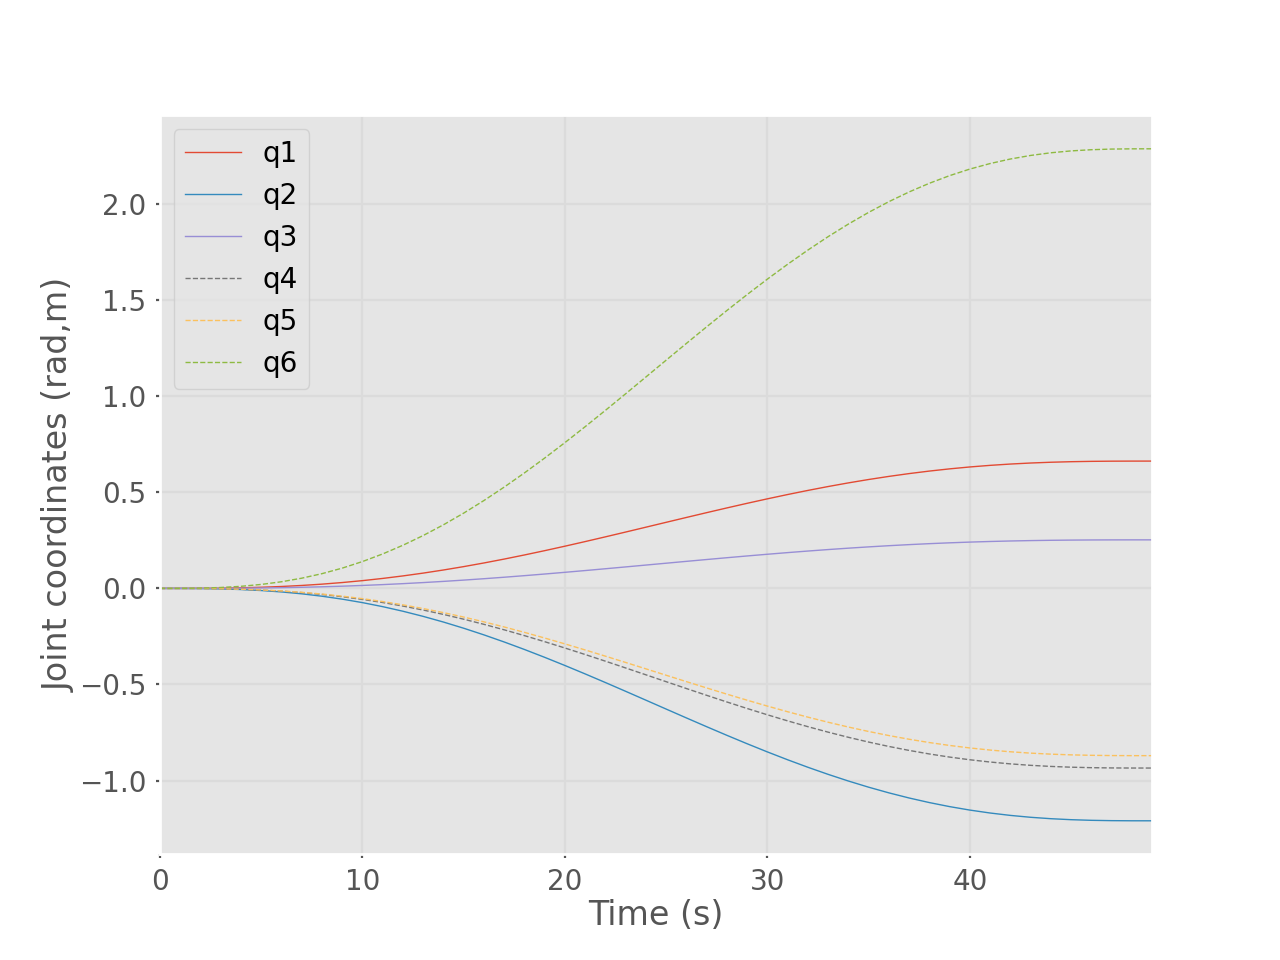

In [15]:
rtb.tools.trajectory.qplot(qt.q, block=True)

and then we can animate this

<IPython.core.display.Javascript object>


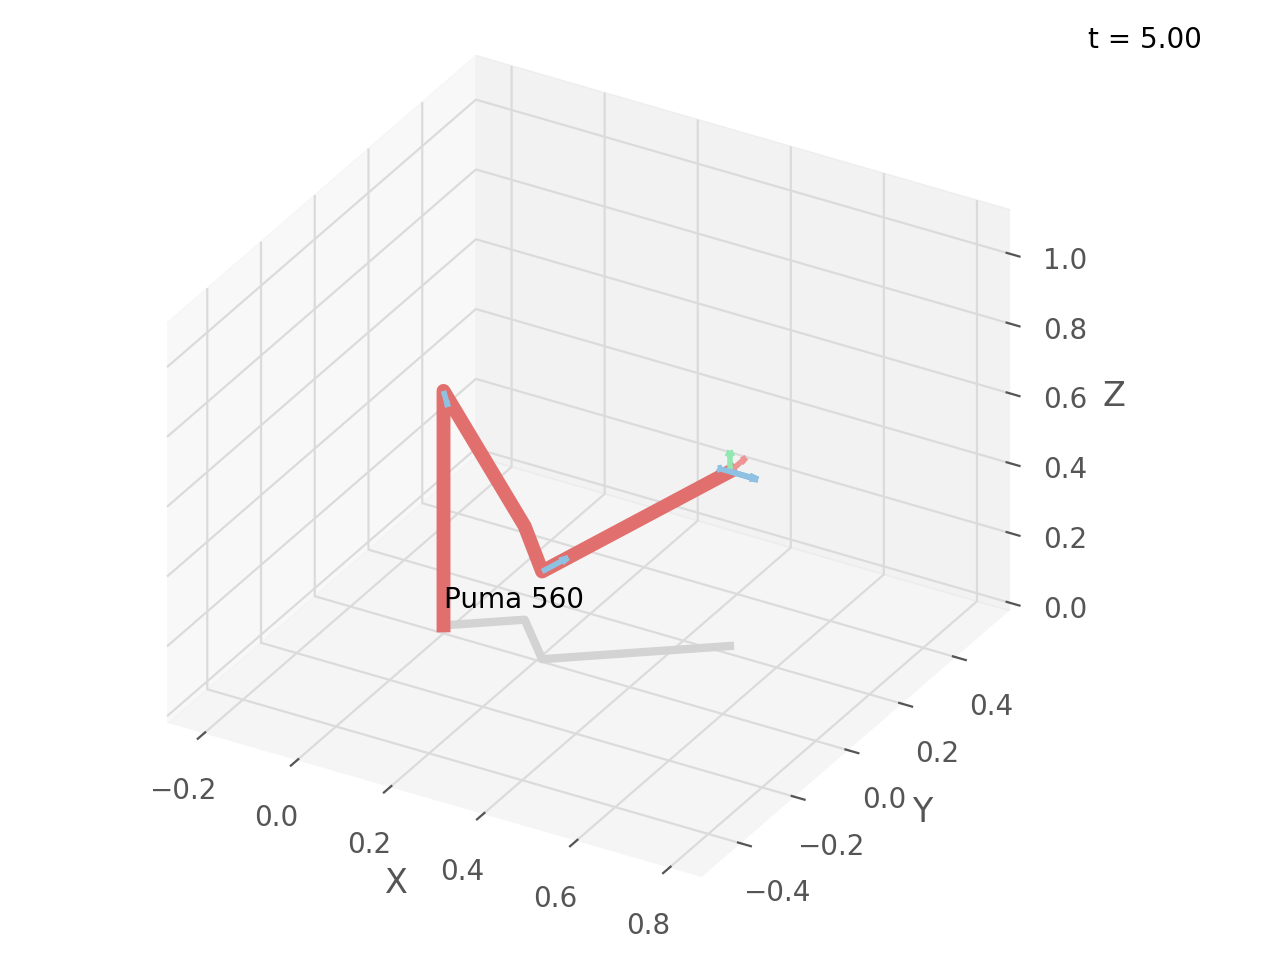

In [16]:
p560.plot(qt.q, dt=0.1);

_Note: animation not working in Jupyter..._

The inverse kinematic solution was found using an iterative numerical procedure.  It is quite general but it has several drawbacks:
- it can be slow
- it may not find a solution, if the initial choice of joint coordinates is far from the solution (in the case above the default initial choice of all zeros was used)
- it may not find the solution you want, in general there are multiple solutions for inverse kinematics.  For the same end-effector pose, the robot might:
    - have it's arm on the left or right of its waist axis, 
    - the elbow could be up or down, and
    - the wrist can flipped or not flipped.  For a two-finger gripper a rotation of 
      180° about the gripper axis leaves the fingers in the same configuration.

Most industrial robots have a _spherical wrist_ which means that the last three joint axes intersect at a single point in the middle of the wrist mechanism.  We can test for this condition

In [ ]:
p560.isspherical()

This greatly simplifies things because the last three joints only control orientation and have no effect on the end-effector position.  This means that only the first three joints define position $(x_e, y_e, z_e)$.  Three joints that control three unknowns is relatively easy to solve for, and analytical solutions (complex trigonmetric equations) can be found, and in fact have been published for most industrial robot manipulators.

The Puma560 has an analytical solution.  We can request the solution with the arm to the left and the elbow up, and the wrist not flipped by using the configuration string `"lun"`


In [ ]:
sol = p560.ikine_a(T, "lun")
sol

which is different to the values found earlier, but we can verify it is a valid solution

In [ ]:
p560.fkine(sol.q)

In fact the solution we found earlier, but didn't explicitly specify, is the right-handed elbow-up configuration

In [ ]:
sol = p560.ikine_a(T, "run")
sol.q

Other useful functions include the manipulator Jacobian which maps joint velocity to end-effector velocity expressed in the world frame

In [ ]:
p560.jacob0(p560.qn)